In [61]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim
import torch
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class_to_name = {0: "Heart", 1: "Baseball", 2: "Smile", 3: "Disappointed",
                4: "Fork and Knife"}

In [107]:
def read_data(path):
    sentences = []
    labels = []
    with open(path, "r") as f:
        for line in f:
            columns = line.split(",")
            sentences.append(columns[0].replace('"',"").lower().strip())
            labels.append(int(columns[1]))
    return sentences, labels

def read_glove_vecs(path):
    word_to_vec_map = {}
    word_to_index = {}
    index_to_word = {}
    with open(path, "r") as f:
        for i, line in enumerate(f):
            columns = line.split(" ")
            word = columns[0]
            vector = columns[1:]
            word_to_vec_map[word] = [float(v.strip()) for v in vector]
            word_to_index[word] = i
            index_to_word[i] = word
    return word_to_index, index_to_word, word_to_vec_map

def sentence_to_avg(sentence, word_to_vec_map):
    avg = np.zeros((50,))
    words = [i.lower() for i in sentence.split()]
    for word in words:
        avg += word_to_vec_map[word]
    avg = avg / len(words)
    return avg

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.linear = nn.Linear(50, 25)
        self.linear2 = nn.Linear(25, 5)
        
    def forward(self, avg):
        return fn.softmax(self.linear2(self.linear(avg)), dim=0)
    
def predict(sentence, classifier):
    avg = sentence_to_avg(sentence, word_to_vec_map)
    avg = torch.FloatTensor(avg).to(device)
    predictions = classifier(avg)
    prediction = predictions.argmax().item()
    return class_to_name[prediction], prediction

def evaluate(sentences, labels, classifier):
    correct = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        label = labels[i]
        class_name, class_index = predict(sentence, classifier)
        correct += class_index == label
    return correct / len(sentences)

## Avg Embeddings Model

In [92]:
n_epochs = 400

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_sentences, train_labels = read_data("/home/tyler/data/text/emoji/train_emoji.csv")
test_sentences, test_labels = read_data("/home/tyler/data/text/emoji/tesss.csv")

In [5]:
max_len = len(max(train_sentences, key=len).split())

In [6]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/home/tyler/data/text/glove/glove.6B.50d.txt')

In [108]:
classifier = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(), lr=.001)

In [109]:
losses = []
for epoch in range(n_epochs):
    sentences, labels = shuffle(train_sentences, train_labels)
    loss_avg = 0
    for i in range(len(sentences)):
        
        classifier.zero_grad()
        
        sentence = sentences[i]
        label = torch.LongTensor([labels[i]]).to(device)
        
        avg = sentence_to_avg(sentence, word_to_vec_map)
        avg = torch.FloatTensor(avg).to(device)
        predictions = classifier(avg)
        loss = criterion(predictions.unsqueeze(0), label)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
    losses.append(loss_avg / len(sentences))

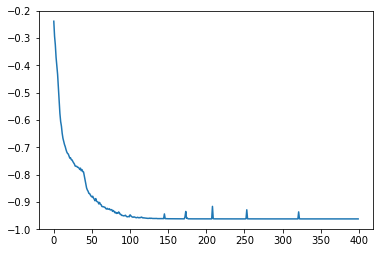

In [110]:
plt.plot(losses)

In [121]:
predict("lets play ball", classifier)

('Baseball', 1)

In [114]:
evaluate(test_sentences, test_labels, classifier)

0.875

In [115]:
evaluate(train_sentences, train_labels, classifier)

0.9621212121212122